In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import normalize
import spectrum
from spectrum import Periodogram, data_cosine

In [5]:
def read_data_files():
    raw_data = pd.DataFrame()
    
    for filename in os.listdir('../data/buy/'):
        if filename.endswith(".txt"): 
            symbol = filename.split("1")[0]
            tmp_df = pd.read_csv(os.path.join('../data/buy/', filename), delimiter= '\s+', header = None)
            tmp_df = tmp_df.astype(float)
            tmp_df = pd.concat([pd.Series([symbol] * tmp_df.shape[0], name = 'symbol'), tmp_df], axis=1)
            tmp_df = tmp_df.iloc[20:,:]
            raw_data = pd.concat([raw_data, tmp_df])
    
    osc_names = ['osc' + str(i+1) for i in range(41)]
    prc_names = ['prc' + str(i+1) for i in range(41)]
    macd_names = ['macd' + str(i+1) for i in range(41)]
    raw_data.columns = ['symbol'] + osc_names + prc_names + macd_names + ['rtn']
    raw_data = raw_data.reset_index(drop=True)
    
    return raw_data

In [6]:
def remove_duplicates(raw_data):
    target_names = list(raw_data.columns)
    del target_names[0]
    clean_data = raw_data.drop_duplicates(subset = target_names)
    clean_data= clean_data.reset_index(drop=True)
    
    return clean_data

In [24]:
def remove_extreme_values(data): 
    data = data[(data['osc1'] > -7) & (data['osc1'] < 7)] 
    data = data.reset_index(drop=True)
    return data

In [8]:
def check_zero_values(data):
    data['n_osc_zero'] = [0] * data.shape[0]
    data['n_prc_zero'] = [0] * data.shape[0]
    data['n_macd_zero'] = [0] * data.shape[0]
    for i in range(data.shape[0]):
        if i%1000 == 0:
            print(i, end=' ')
        data.iloc[i, -3] = sum(data.iloc[i, 1:42] == 0)
        data.iloc[i, -2] = sum(data.iloc[i, 42:83] == 0)
        data.iloc[i, -1] = sum(data.iloc[i, 83:124] == 0)
    return data

In [25]:
def remove_pos_values(data):
    data = data[data['osc1'] < 0]
    data = data.reset_index(drop=True)
    return data

In [10]:
def standardize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - np.mean(row))/np.std(row) 
    return data 

In [11]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [12]:
def sep_stock_data(data): 
    
    symbol = pd.Series(data['symbol'], name = 'symbol')
    osc_data = data.iloc[:, 1:42]
    osc_data = osc_data[osc_data.columns[::-1]]
    prc_data = data.iloc[:, 42:83]
    prc_data = prc_data[prc_data.columns[::-1]]
    macd_data = data.iloc[:, 83:124]
    macd_data = macd_data[macd_data.columns[::-1]]
    rtn = pd.Series(data.iloc[:, 124], name = 'rtn')
    label = pd.Series(map(lambda x: 1 if x>0 else 0, rtn), name = 'label')
    
    return symbol, osc_data, prc_data, macd_data, rtn, label

In [13]:
def calc_derivative(data, name):
    derivatives = []
    for i in range(data.shape[0]):
        i_derivative = list(np.gradient(pd.Series(data.iloc[i,:])))
        derivatives.append(i_derivative)
    
    names = []
    for i in range(data.shape[1]):
        names.append(name + "_d"+ str(i)) 
    
    return pd.DataFrame(derivatives, columns=names, index=data.index)

In [38]:
def psd_calculator(data, name, NFFT = 100):
    """
    calculate the psd seq as new feature. 
    this is a copy of the function from https://github.com/UBC-MDS/DSCI_591_capstone-Seahorse/blob/master/src/week4/RandomForest_Exploring_Q%26A_inluded.ipynb
    """ 

    freq = []
    for i in range(data.shape[0]):
        data_osc = data.iloc[i,:]
        p = Periodogram(data_osc, NFFT=NFFT)
        temp_list = list(p.psd)
        freq.append(temp_list)

    col_name = []
    for i in range(int(NFFT/2)+1):
        col_name.append(name+ "_psd"+str(i))
    
    psd_df = pd.DataFrame(freq, columns=col_name)
    psd_df.index = data.index
        
    return psd_df

In [15]:
def cal_smoothness(data): 
    smoothness = []
    for i in range(data.shape[0]):
      smoothness.append(np.var(abs(np.diff(data.iloc[i,:]))))
    smoothness = pd.Series(smoothness, name='smoothness', index=data.index)
    return smoothness

In [16]:
def eng_osc_features(osc_data):
    # new feature 'smoothness' - how smooth is the curve? 
    smoothness = cal_smoothness(osc_data)

    # new features to record oscillator level 
    oscn6 = pd.Series(map(lambda x: True if x <= -6 else False, osc_data['osc1']), name='oscn6')
    oscn63 = pd.Series(map(lambda x: True if (x > -6 and x <= -3) else False, osc_data['osc1']), name='oscn63')
    oscn30 = pd.Series(map(lambda x: True if (x > -3 and x <= 0) else False, osc_data['osc1']), name='oscn30')
    osc03 = pd.Series(map(lambda x: True if (x > 0 and x <= 3) else False, osc_data['osc1']), name='osc03')
    osc36 = pd.Series(map(lambda x: True if (x > 3 and x <= 6) else False, osc_data['osc1']), name='osc36')
    osc6 = pd.Series(map(lambda x: True if x >= 6 else False, osc_data['osc1']), name='osc6')

    # new features to record 1st derivatives 
    osc_derv = calc_derivative(osc_data, name="osc")
    osc_psd = psd_calculator(osc_data, name="osc")
    new_osc_features = pd.concat([smoothness, oscn6, oscn63, oscn30, osc03, osc36, osc6, osc_derv], axis = 1)
    new_osc_features.index = osc_data.index

    return new_osc_features

In [17]:
def eng_prc_features(prc_data): 
    # new feature 'spike' - price spike? 
    spike = pd.Series(map(lambda x1, x2: 1 if x1/x2 > 1.05 else 0, prc_data['prc1'], prc_data['prc2']), name='spike')
    
    # new feature 'lower20' - price is at the bottom 20% zone? 
    # new feature 'flat' - price is flat in the last 6 bars? 
    lower20 = [] 
    flat = []
    for i in range(prc_data.shape[0]):
        max_prc = max(prc_data.iloc[i, :])
        min_prc = min(prc_data.iloc[i, :])
        prc_range = max_prc - min_prc 
        if prc_data.iloc[i, 40] - min_prc <=  min_prc + 0.2 * prc_range:
            lower20.append(1)
        else: 
            lower20.append(0)
        last_6_range = max(prc_data.iloc[i, 35:]) - min(prc_data.iloc[i, 35:]) 
        if last_6_range <= 0.2 * prc_range:
            flat.append(1)
        else:
            flat.append(0)        
    lower20 = pd.Series(lower20, name='lower20') 
    flat = pd.Series(flat, name='flat')
    
    prc_derv = calc_derivative(prc_data, name="prc")
    
    new_prc_features = pd.concat([spike, lower20, flat, prc_derv], axis=1) 
    new_prc_features.index = prc_data.index
    
    return new_prc_features

In [18]:
def eng_macd_features(macd_data):
    # new features to record whether MACD is up in the last 1 to 5 bars
    macd_up1 = pd.Series(macd_data['macd1'] > macd_data['macd2'], name='macd_up1')
    macd_up2 = pd.Series(macd_up1 & (macd_data['macd2'] > macd_data['macd3']), name='macd_up2')
    macd_up3 = pd.Series(macd_up2 & (macd_data['macd3'] > macd_data['macd4']), name='macd_up3')
    macd_up4 = pd.Series(macd_up3 & (macd_data['macd4'] > macd_data['macd5']), name='macd_up4')
    macd_up5 = pd.Series(macd_up4 & (macd_data['macd5'] > macd_data['macd6']), name='macd_up5')
    
    # new feature 'macd_co' - MACD crossover upward in the last three bars? 
    macd_co = pd.Series(map(lambda x1, x2: True if (x1 > 0 and x2 < 0) else False, macd_data['macd1'], macd_data['macd3']), 
                        name='macd_co')
    
    macd_derv = calc_derivative(macd_data, name="macd")
    macd_psd = psd_calculator(macd_data, name='macd')
    
    new_macd_features = pd.concat([macd_up1, macd_up2, macd_up3, macd_up4, macd_up5, macd_co, macd_derv, macd_psd], axis = 1)
    new_macd_features.index = macd_data.index 
    
    return new_macd_features

In [46]:
def save_new_data(clean_data):
    clean_data = clean_data.reset_index(drop = True)
    symbol, osc_data, prc_data, macd_data, rtn, label = sep_stock_data(clean_data) 
    new_osc_features = eng_osc_features(osc_data)
    new_prc_features = eng_prc_features(prc_data)
    new_macd_features = eng_macd_features(macd_data) 
    osc_normalized = normalize_data(osc_data)
    prc_normalized = normalize_data(prc_data)
    macd_normalized = normalize_data(macd_data)

    D1 = pd.concat([osc_data, prc_data, macd_data, 
                    symbol, rtn, label], axis = 1)
    D2 = pd.concat([osc_data, prc_data, macd_data, 
                    new_prc_features, new_osc_features, new_macd_features, 
                    symbol, rtn, label], axis = 1)
    D3 = pd.concat([osc_normalized, prc_normalized, macd_normalized, 
                    new_prc_features, new_osc_features, new_macd_features, 
                    symbol, rtn, label], axis = 1)
    D4 = pd.concat([osc_data, prc_data, macd_data, 
                    osc_normalized, prc_normalized, macd_normalized, 
                    new_prc_features, new_osc_features, new_macd_features, 
                    symbol, rtn, label], axis = 1)
    D1.to_csv('../data/D1.csv')
    D2.to_csv('../data/D2.csv')
    D3.to_csv('../data/D3.csv')
    D4.to_csv('../data/D4.csv')

In [35]:
dat1 = read_data_files()
dat1.shape

(102631, 125)

In [36]:
dat2 = remove_duplicates(dat1)
dat2.shape

(101904, 125)

In [37]:
dat2 = remove_extreme_values(dat2)
dat2.shape

(100987, 125)

In [47]:
# save data that contain low price records
save_new_data(dat2)

In [78]:
dat3 = dat2[dat2['prc1'] > 5]
dat3.shape

(96030, 125)

In [79]:
# save data that don't contain low price records
save_new_data(dat3)

In [53]:
class StockData():
    def __init__(self, file_path):
        
        data = pd.read_csv(file_path, header=0, index_col=0) 
        y = data['label'] 
        X = data.drop(['symbol', 'label'], axis = 1)
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        
        # balance the train_valid data set
        balance_data_set = True
        if balance_data_set:
            df = pd.concat([X_train_valid_w_rtn, y_train_valid], axis=1)
            tmp_pos = df[df['rtn'] > 0] 
            tmp_neg = df[df['rtn'] < 0] 
            if tmp_pos.shape[0] > tmp_neg.shape[0]: 
                tmp_pos = tmp_pos.sample(tmp_neg.shape[0])
            elif tmp_pos.shape[0] < tmp_neg.shape[0]:
                tmp_neg = tmp_neg.sample(tmp_pos.shape[0])
            df = pd.concat([tmp_pos, tmp_neg], axis = 0)
            y_train_valid = df['label']
            X_train_valid_w_rtn = df.drop(['label'], axis = 1)
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.33) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        # train set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # valid set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [77]:
class SeahorseBuyModel(): 
    def __init__(self):
        self.clf = RandomForestClassifier(n_estimators = 32, max_depth = 50)
        self.features = []
        return 
    
    def fit(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        self.features = X_train.columns
        return
    
    def evaluate(self, X, y, rtn):
        probs = self.clf.predict_proba(X)

        win_probs = []
        for i in range(len(probs)):
            win_probs.append(probs[i][1])

        trade_classes = [int(x * 10)/10 for x in win_probs]
            
        results = pd.concat([pd.Series(win_probs, name='win_prob'), 
                             pd.Series(trade_classes, name='trade_class'), 
                             y.reset_index(drop=True), 
                             rtn.reset_index(drop=True)], 
                            axis = 1)

        summary = pd.concat([results.groupby(['trade_class']).mean(), 
                             results.groupby(['trade_class']).count()['win_prob'], 
                             100 * results.groupby(['trade_class']).count()['win_prob']/results.shape[0]], 
                            axis=1)
        summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
        # summary = summary.reindex([i/10 for i in range(10)])
        print(summary.to_string())
        return 
    
    def feature_importances(self):
        f = {'f_name': list(self.features), 
             'f_importance': list(self.clf.feature_importances_)}
        f = pd.DataFrame(f)
        f = f.sort_values(by=['f_importance'], ascending=False)
        return f

In [80]:
for filename in os.listdir('../data/'):
    if filename.endswith(".csv"): 
        file_path = os.path.join('../data/', filename)
        stock_data = StockData(file_path)
        model = SeahorseBuyModel()
        model.fit(stock_data.X_train, stock_data.y_train)
        print('using data file', filename)
        model.evaluate(stock_data.X_valid, stock_data.y_valid, stock_data.valid_rtn)

using data file D1.csv
             predicted win prob  actual win rate  mean return  # of trades  % of all trades
trade_class                                                                                
0.1                    0.177170         0.333333    -0.361333           15         0.076316
0.2                    0.264842         0.492582     0.125549          337         1.714576
0.3                    0.354345         0.491391     0.216203         2149        10.933605
0.4                    0.442772         0.496855     0.207195         6042        30.740270
0.5                    0.540689         0.506537     0.242127         8643        43.973544
0.6                    0.645308         0.530726     0.355228         2148        10.928517
0.7                    0.732281         0.503226     0.201935          310         1.577207
0.8                    0.821648         0.400000    -0.190000           10         0.050878
0.9                    0.906250         1.000000     1.08

In [63]:
tmp = pd.read_csv('../data/D1all.csv', header=0, index_col=0) 
data.head()

,osc41,osc40,osc39,osc38,osc37,osc36,osc35,osc34,osc33,osc32,...,macd7,macd6,macd5,macd4,macd3,macd2,macd1,symbol,rtn,label
0,0.490831,0.397519,0.259439,0.134844,0.042611,0.018878,0.000000,0.012406,0.018339,0.007012,...,0.787037,0.777778,0.814815,0.842593,0.851852,0.879630,0.879630,acad,-1.06,0
1,0.134844,0.042611,0.018878,0.000000,0.012406,0.018339,0.007012,0.059871,0.100324,0.126753,...,0.822917,0.833333,0.864583,0.864583,0.854167,0.833333,0.822917,acad,-0.53,0
2,0.018878,0.000000,0.012406,0.018339,0.007012,0.059871,0.100324,0.126753,0.161273,0.195254,...,0.858696,0.858696,0.847826,0.826087,0.815217,0.793478,0.793478,acad,-5.32,0
3,0.548205,0.580000,0.618974,0.649231,0.675385,0.656410,0.607179,0.539487,0.473846,0.383590,...,0.500000,0.464286,0.482143,0.500000,0.482143,0.482143,0.464286,acad,-0.56,0
4,0.618974,0.649231,0.675385,0.656410,0.607179,0.539487,0.473846,0.383590,0.288205,0.183590,...,0.482143,0.500000,0.482143,0.482143,0.464286,0.446429,0.446429,acad,-5.03,0


In [64]:
data.tail()

,osc41,osc40,osc39,osc38,osc37,osc36,osc35,osc34,osc33,osc32,...,macd7,macd6,macd5,macd4,macd3,macd2,macd1,symbol,rtn,label
100982,0.600000,0.492857,0.371429,0.200000,0.278571,0.328571,0.435714,0.500000,0.585714,0.678571,...,0.553398,0.475728,0.422330,0.288026,0.257282,0.242718,0.229773,uri,-0.33,0
100983,0.815287,0.993631,0.942675,0.929936,0.910828,0.910828,1.000000,0.898089,0.770701,0.643312,...,0.408163,0.464853,0.374150,0.242630,0.197279,0.195011,0.215420,uri,-0.11,0
100984,0.911392,0.911392,1.000000,0.898734,0.772152,0.645570,0.563291,0.493671,0.392405,0.297468,...,0.233871,0.231183,0.255376,0.303763,0.287634,0.247312,0.303763,uri,1.04,1
100985,0.937107,0.962264,0.993711,0.974843,1.000000,0.981132,0.874214,0.754717,0.635220,0.597484,...,0.000000,0.040404,0.161616,0.232323,0.228956,0.228956,0.208754,uri,-0.86,0
100986,0.834532,0.866906,0.928058,0.982014,0.996403,1.000000,0.985612,0.978417,0.971223,0.938849,...,0.037862,0.082405,0.160356,0.171492,0.256125,0.342984,0.505568,uri,4.55,1


In [0]:
model = SeahorseBuyModel()
model.fit(stock_data.X_train, stock_data.y_train)

In [46]:
model.evaluate(stock_data.X_valid, stock_data.y_valid, stock_data.valid_rtn)

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
trade_class,,,,,
Buy1,0.826389,0.555556,0.244444,9,0.045429
Buy2,0.781250,0.428571,-0.216667,21,0.106002
Buy3,0.727438,0.467532,0.106234,231,1.166019
Buy4,0.666863,0.523949,0.238446,1023,5.163798
Others,0.487003,0.502165,0.227160,18474,93.251224
Sell3,0.220899,0.486486,-0.267297,37,0.186765
Sell2,0.181747,0.428571,-0.162857,14,0.070668
Sell1,0.125000,0.500000,-0.970000,2,0.010095


In [47]:
model.evaluate(stock_data.X_test, stock_data.y_test, stock_data.test_rtn)

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
trade_class,,,,,
Buy1,0.830729,0.500000,0.549167,12,0.049605
Buy2,0.780933,0.481481,0.129630,27,0.111612
Buy3,0.729237,0.437908,0.203464,306,1.264933
Buy4,0.667121,0.432998,0.065687,1194,4.935720
Others,0.487419,0.417563,0.064566,22593,93.394238
Sell3,0.221364,0.342857,-0.074571,35,0.144682
Sell2,0.176739,0.391304,0.005217,23,0.095077
Sell1,0.125000,1.000000,0.250000,1,0.004134


In [76]:
print(result.to_string())

             predicted win prob  actual win rate  mean return  # of trades  % of all trades
trade_class                                                                                
0.1                    0.174107         0.857143     0.721429            7         0.034115
0.2                    0.265839         0.491961     0.195691          311         1.515668
0.3                    0.354277         0.494872     0.169470         2340        11.404065
0.4                    0.441064         0.500381     0.230193         6565        31.994737
0.5                    0.541339         0.506661     0.249617         8858        43.169745
0.6                    0.645857         0.514286     0.277419         2135        10.404990
0.7                    0.731661         0.501754     0.242281          285         1.388957
0.8                    0.819602         0.388889     0.056111           18         0.087724


In [0]:
dat3 = remove_nonsense_data(dat2)
dat3.shape

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 

(101904, 128)

(array([446., 271., 178., 131.,  94.,  56.,  48.,  45.,  43.,  20.,  13.,
         11.,  13.,   6.,   2.,   3.,   2.,   5.,   5.,   4.,   3.,   5.]),
 array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
        18., 19., 20., 21., 22., 23., 24., 25., 26., 27.]),
 <a list of 22 Patch objects>)

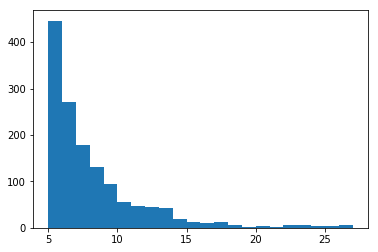

In [0]:
dat3_subset = dat3[dat3['n_macd_zero'] >= 5]
plt.hist(dat3_subset['n_macd_zero'], bins = 22)

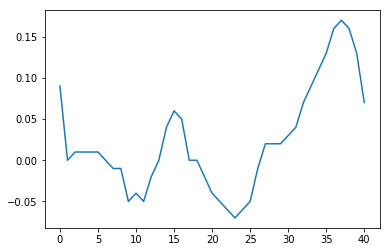

In [0]:
plt.plot(range(41), dat3_subset.iloc[0, 83:124])

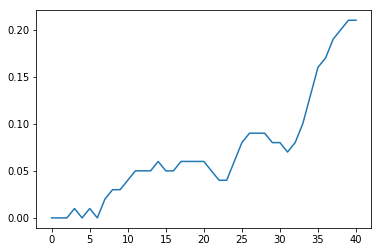

In [0]:
plt.plot(range(41), dat3_subset.iloc[1, 83:124])

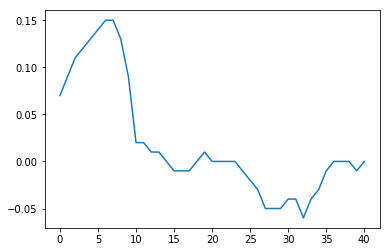

In [0]:
dat3_subset_10 = dat3_subset[dat3_subset['n_macd_zero'] == 10]
plt.plot(range(41), dat3_subset_10.iloc[0, 83:124])

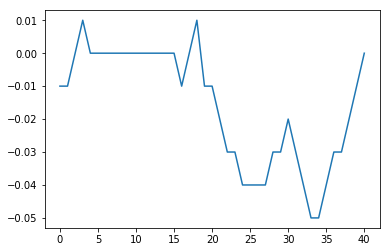

In [0]:
dat3_subset_15 = dat3_subset[dat3_subset['n_macd_zero'] == 15]
plt.plot(range(41), dat3_subset_15.iloc[0, 83:124])

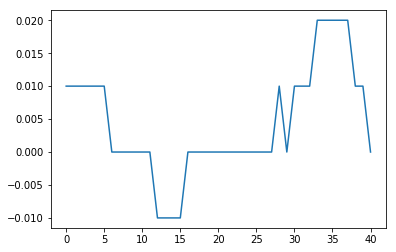

In [0]:
dat3_subset_20 = dat3_subset[dat3_subset['n_macd_zero'] == 20]
plt.plot(range(41), dat3_subset_20.iloc[0, 83:124])

Stock: acad


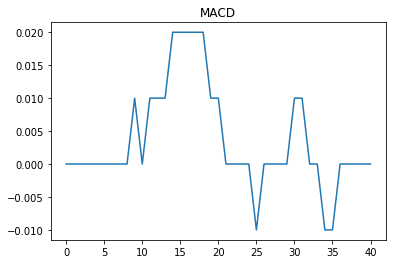

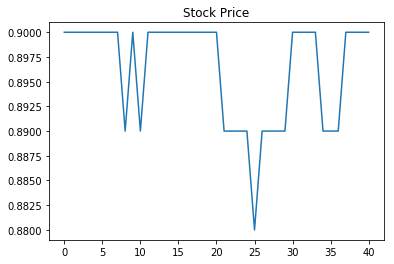

In [0]:
dat3_subset_25 = dat3_subset[dat3_subset['n_macd_zero'] == 25]
print("Stock:", dat3_subset_25.iloc[0, 0])
plt.plot(range(41), dat3_subset_25.iloc[0, 83:124])
plt.title("MACD")
plt.show()
plt.plot(range(41), dat3_subset_25.iloc[0, 42:83])
plt.title("Stock Price")
plt.show()

In [0]:
acad_prc = dat1[dat1['symbol'] == 'acad'].iloc[:, 42:83]
acad_prc[acad_prc['prc0'] == 0.90].head()

,prc0,prc1,prc2,prc3,prc4,prc5,prc6,prc7,prc8,prc9,prc10,prc11,prc12,prc13,prc14,prc15,prc16,prc17,prc18,prc19,prc20,prc21,prc22,prc23,prc24,prc25,prc26,prc27,prc28,prc29,prc30,prc31,prc32,prc33,prc34,prc35,prc36,prc37,prc38,prc39,prc40
515,0.9,0.90,0.90,0.89,0.90,0.92,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.92,0.92,0.91,0.92,0.92,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.92,0.93,0.92,0.92,0.92,0.92,0.93,0.94,0.93,0.93,0.93,0.94,0.93
516,0.9,0.90,0.90,0.90,0.90,0.90,0.90,0.89,0.90,0.92,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.92,0.92,0.91,0.92,0.92,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.92,0.93,0.92,0.92,0.92,0.92,0.93,0.94,0.93
519,0.9,0.90,0.90,0.90,0.90,0.90,0.89,0.90,0.89,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.89,0.89,0.89,0.89,0.88,0.89,0.89,0.89,0.89,0.90,0.90,0.90,0.90,0.89,0.89,0.89,0.90,0.90,0.90,0.90,0.90,0.90
520,0.9,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.89,0.90,0.89,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.89,0.89,0.89,0.89,0.88,0.89,0.89,0.89,0.89,0.90,0.90,0.90,0.90,0.89,0.89,0.89,0.90,0.90,0.90,0.90
522,0.9,0.89,0.89,0.89,0.88,0.89,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.89,0.90,0.89,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.89,0.89,0.89,0.89,0.88,0.89,0.89,0.89,0.89,0.90,0.90,0.90


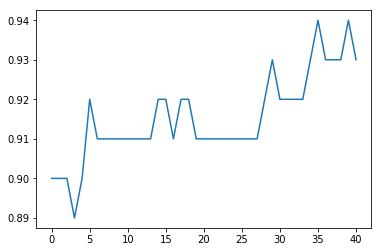

In [0]:
plt.plot(range(41), acad_prc[acad_prc['prc0'] == 0.90].iloc[0, :])

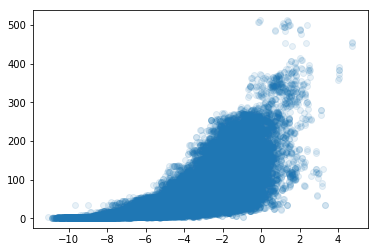

In [0]:
tmp = prc_data.sort_values(['smoothness'], ascending = True)
# tmp = tmp.iloc[:10000, :]
plt.scatter(np.log(tmp['smoothness']), tmp['prc0'], alpha=0.1)
# np.corrcoef(tmp['smoothness'], tmp['prc0'])

In [3]:
tmp = pd.read_csv("../data/buy/amd1Buy3ML20years.txt", delimiter= '\s+', header = None)

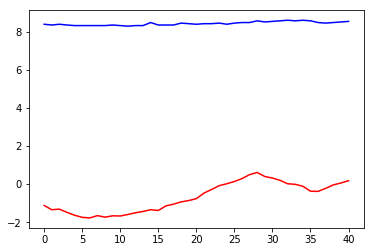

In [22]:
plt.plot(range(41), tmp.iloc[10, :41], "r", label = "oscillator")
plt.plot(range(41), tmp.iloc[10, 41:82], "b", label = "price")
plt.savefig("../gl/plt1.png")

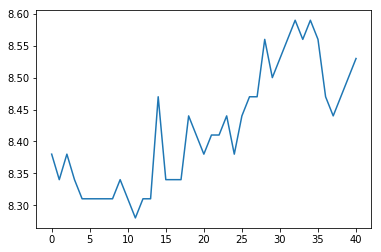

In [13]:
plt2 = plt.plot(range(41), tmp.iloc[10,41:82])
plt2

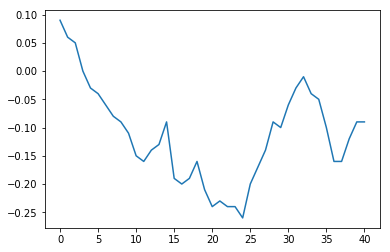

In [19]:
plt3 = plt.plot(range(41), tmp.iloc[10,82:123])
plt.savefig("../gl/plt3.png")

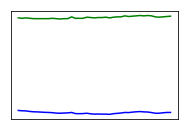

In [66]:
fig = plt.figure(figsize = (3, 2), frameon=False)
fig.tight_layout(pad=0)
plt.plot(range(41), tmp.iloc[10,41:82], 'g')
plt.plot(range(41), tmp.iloc[10,82:123], 'b')
plt.tick_params(axis = 'both', which = 'both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
plt.savefig("../gl/plt0.png")

In [52]:
data[10, 10, :]

array([255, 255, 255], dtype=uint8)

In [57]:
counts = [[0], [0], [0]]
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(3):
            if data[i, j, k] != 255:
                counts[k].append(data[i, j, k])

In [58]:
len(counts[0])

1105

In [59]:
len(counts[1])

3072

In [60]:
len(counts[2])

3072

In [61]:
counts[2][:10]

[0, 19, 51, 51, 51, 51, 51, 51, 51, 51]